<a href="https://colab.research.google.com/github/Jevaan21/intrusion-detection-dl/blob/main/intrusion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pandas scikit-learn tensorflow matplotlib seaborn



In [70]:
!pip install tensorflow


In [72]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.ensemble import ExtraTreesClassifier



In [73]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
df = pd.read_csv('/content/drive/MyDrive/intrusion-detection-dl/UNSW_NB15_training-set.csv')


In [75]:
df.nunique()  # Shows how many unique values each column has



,0
id,175341
dur,74039
proto,133
service,13
state,9
spkts,480
dpkts,443
sbytes,7214
dbytes,6660
rate,76991


In [76]:
# === 3. CLEANING & PREPROCESSING ===
# Drop 'id' column if present
if 'id' in df.columns:
    df.drop('id', axis=1, inplace=True)

# Drop missing values in 'attack_cat' if you're using it
df = df[df['attack_cat'].notnull()]

Preproessing

Encode Categorical Columns

In [77]:
# Encode categorical columns
categorical_cols = ['proto', 'service', 'state', 'attack_cat']
le = LabelEncoder()
df_encoded = df.copy()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])


Extra Trees Classifier

In [78]:
# Step: Feature Selection using Extra Trees
etc = ExtraTreesClassifier(n_estimators=100, random_state=42)
etc.fit(X, y)

# Get feature importances
importances = etc.feature_importances_

# Put them in a DataFrame for easy viewing
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top N features
top_features = importances_df.head(20)['Feature'].tolist()
print("Top 20 selected features:\n", top_features)


Top 20 selected features:
 ['attack_cat', 'sttl', 'ct_state_ttl', 'dttl', 'state', 'swin', 'dwin', 'dload', 'rate', 'ct_srv_dst', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'dmean', 'ct_srv_src', 'smean', 'service', 'tcprtt', 'is_sm_ips_ports', 'ct_src_dport_ltm', 'sinpkt']


Filter dataset to only use top features

In [79]:
# Select only top 20 features
X = X[top_features]


Split Features and Target

In [80]:
# === 4. SELECT FEATURES & TARGET ===
# Binary classification using 'label' column (0=normal, 1=attack)
X = df_encoded.drop('label', axis=1)
y = df_encoded['label']

 Feature Scaling

In [81]:
# === 5. SCALE FEATURES ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [82]:
# === 6. SPLIT DATA ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

Build and Train the DNN Model

In [87]:
# === 7. BUILD DNN MODEL ===
# Build the DNN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Evaluate the Model

In [88]:
# Train the model
print("🔁 Training the model...")
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2, verbose=1)


🔁 Training the model...
Epoch 1/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9207 - loss: 0.1895 - val_accuracy: 0.9980 - val_loss: 0.0096
Epoch 2/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9966 - loss: 0.0141 - val_accuracy: 0.9997 - val_loss: 0.0012
Epoch 3/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9984 - loss: 0.0052 - val_accuracy: 0.9999 - val_loss: 4.0299e-04
Epoch 4/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9994 - loss: 0.0036 - val_accuracy: 0.9999 - val_loss: 2.3174e-04
Epoch 5/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 2.6631e-04


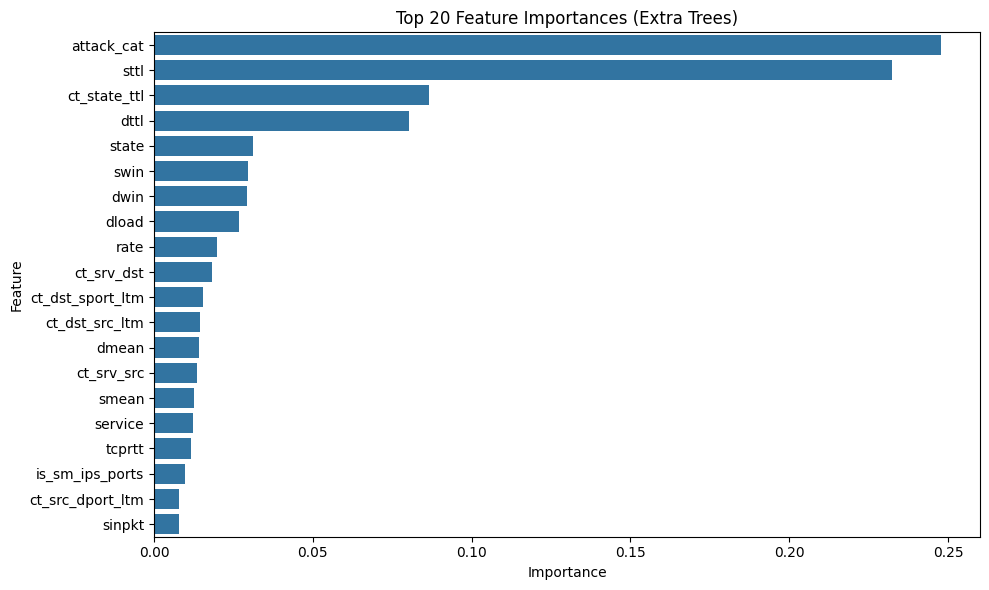

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(20))
plt.title('Top 20 Feature Importances (Extra Trees)')
plt.tight_layout()
plt.show()


Visualize Training Performance

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step
✅ Model evaluation complete:
Confusion Matrix:
 [[11169     0]
 [    1 23899]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11169
           1       1.00      1.00      1.00     23900

    accuracy                           1.00     35069
   macro avg       1.00      1.00      1.00     35069
weighted avg       1.00      1.00      1.00     35069

ROC AUC Score: 0.9999999962538272


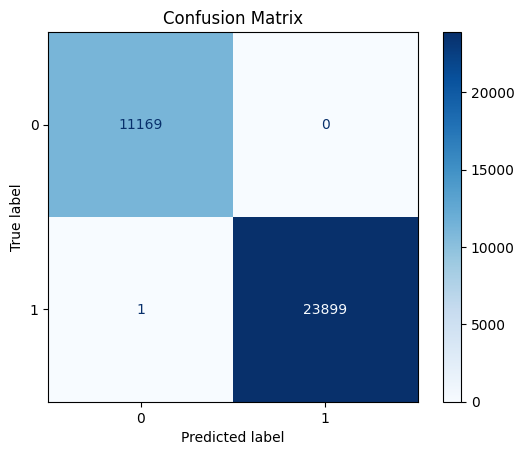

In [90]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

# Predict
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()

# Evaluation
print("✅ Model evaluation complete:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_classes))
print("Classification Report:\n", classification_report(y_test, y_pred_classes))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


 Confusion Matrix

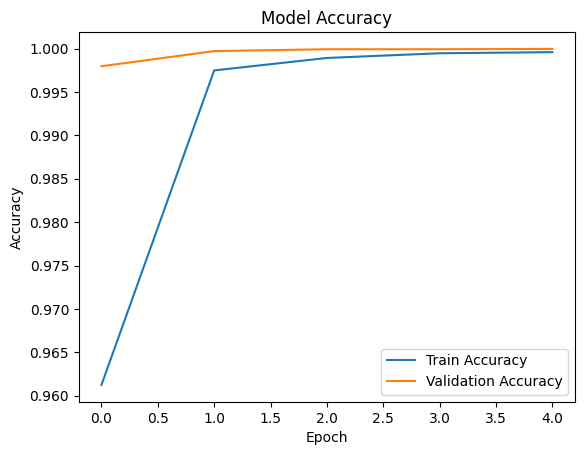

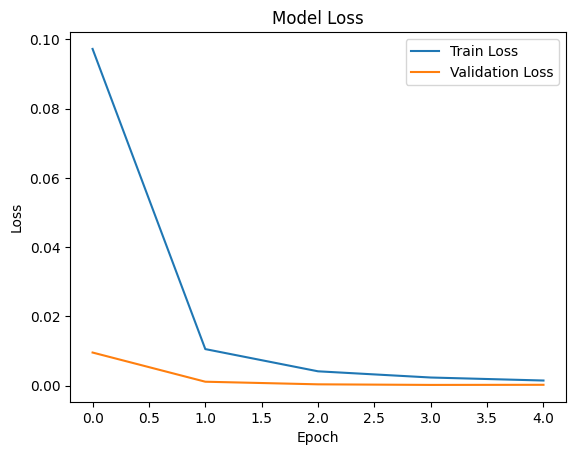

In [93]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
